In [1]:
#import libraris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Main data columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']
IP mapping columns: ['lower_bound_ip_address', 'upper_bound_ip_address', 'country']
Sample IP bounds:    lower_bound_ip_address  upper_bound_ip_address
0              16777216.0                16777471
1              16777472.0                16777727
2              16777728.0                16778239
3              16778240.0                16779263
4              16779264.0                16781311
Countries mapped: 1

Top 10 High Fraud Rate Countries:
          count      mean    sum
country                         
Unknown  151112  0.093646  14151


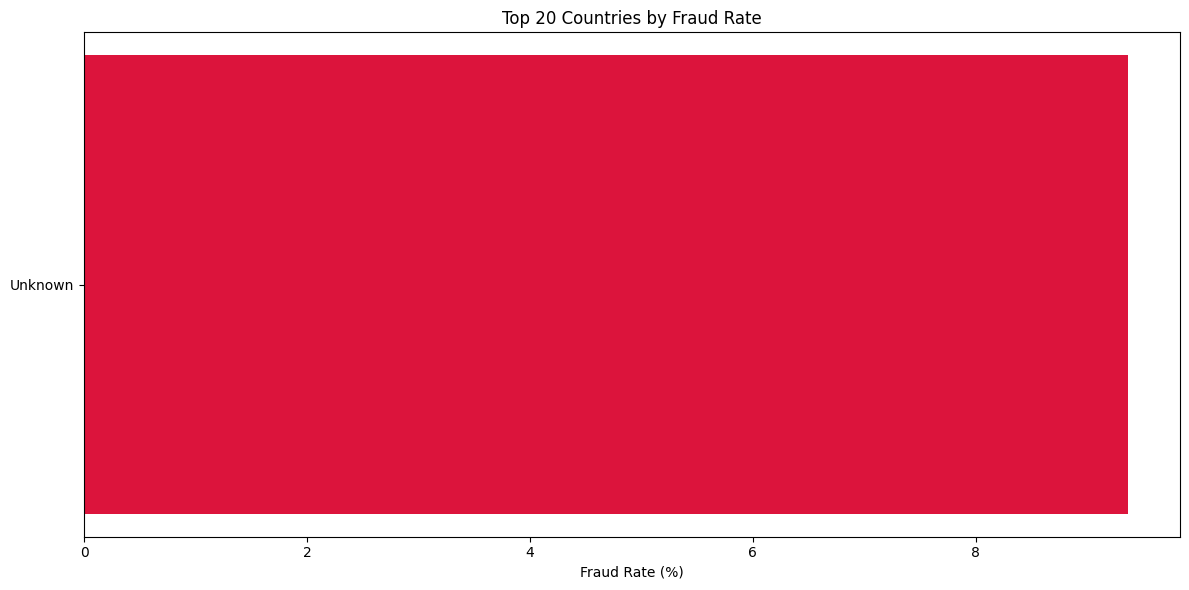

In [2]:
import ipaddress

# Load main data and IP-country mapping
df = pd.read_csv(r'C:\Users\admin\fraud-detection-week5\data\raw\Fraud_Data.csv')  # replace with your file
ip_df = pd.read_csv(r'C:\Users\admin\fraud-detection-week5\data\raw\IpAddress_to_Country.csv')

print("Main data columns:", df.columns.tolist())
print("IP mapping columns:", ip_df.columns.tolist())

# Step 1: Convert main df's ip_address to integer
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except:
        return None

df['ip_int'] = df['ip_address'].apply(ip_to_int)

# Step 2: Ensure IP range bounds in ip_df are integers (they usually are, but confirm)
# If they're strings, convert them — but typically they're already ints
print("Sample IP bounds:", ip_df[['lower_bound_ip_address', 'upper_bound_ip_address']].head())

# Step 3: Function to map IP int to country using ip_df
def find_country(ip_int):
    if pd.isna(ip_int):
        return 'Unknown'
    # Search for matching range
    match = ip_df[
        (ip_df['lower_bound_ip_address'] <= ip_int) &
        (ip_df['upper_bound_ip_address'] >= ip_int)
    ]
    if not match.empty:
        return match.iloc[0]['country']
    return 'Unknown'

# Step 4: Apply to main DataFrame
df['country'] = df['ip_int'].apply(find_country)
print(f"Countries mapped: {df['country'].nunique()}")

# Step 5: Analyze fraud by country (assuming 'class' = 1 means fraud)
country_fraud = df.groupby('country')['class'].agg(['count', 'mean', 'sum']).sort_values('mean', ascending=False)
print("\nTop 10 High Fraud Rate Countries:")
print(country_fraud.head(10))

# Step 6: Plot
plt.figure(figsize=(12, 6))
top_20 = country_fraud.head(20)
plt.barh(top_20.index, top_20['mean'] * 100, color='crimson')
plt.xlabel('Fraud Rate (%)')
plt.title('Top 20 Countries by Fraud Rate')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(r'C:\Users\admin\fraud-detection-week5\reports\fraud_by_country.png', dpi=300)
plt.show()

In [4]:
import pandas as pd

# ---- 0. Ensure datetime columns ----
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['signup_time'] = pd.to_datetime(df['signup_time'])

# ---- 1. Time-based features ----
df['hour_of_day'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# ---- 2. Time since signup ----
df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600

# ---- 3. Transaction frequency & velocity features ----
df = df.sort_values(['user_id', 'purchase_time', 'purchase_value'])

# Time since last transaction per user
df['time_since_last_txn'] = df.groupby('user_id')['purchase_time'].diff().dt.total_seconds() / 60

# ---- Robust rolling counts & sums ----
# We'll use a helper function to avoid duplicate datetime issues
def rolling_feature(group, value_col, window, agg='count'):
    group = group.copy()
    group = group.sort_values('purchase_time')
    # Add a tiny offset to duplicates to make index unique
    group['purchase_time_index'] = group['purchase_time'] + pd.to_timedelta(range(len(group)), unit='ns')
    group = group.set_index('purchase_time_index')
    if agg == 'count':
        return group[value_col].rolling(window).count().values
    elif agg == 'sum':
        return group[value_col].rolling(window).sum().values

# Rolling transaction count in last 24h and 7d
df['txn_count_24h'] = df.groupby('user_id', group_keys=False).apply(lambda x: rolling_feature(x, 'user_id', '24h', 'count'))
df['txn_count_7d'] = df.groupby('user_id', group_keys=False).apply(lambda x: rolling_feature(x, 'user_id', '7d', 'count'))

# Purchase velocity in last 1h
df['purchase_velocity_1h'] = df.groupby('user_id', group_keys=False).apply(lambda x: rolling_feature(x, 'purchase_value', '1h', 'sum'))

# Average purchase per user
df['avg_purchase_user'] = df.groupby('user_id')['purchase_value'].transform('mean')

# Unique devices per user
df['unique_devices_per_user'] = df.groupby('user_id')['device_id'].transform('nunique')

# ---- Summary ----
print(f"Total features created: {len(df.columns)}")
print(f"New features: hour_of_day, day_of_week, is_weekend, time_since_signup, "
      f"time_since_last_txn, txn_count_24h, txn_count_7d, "
      f"purchase_velocity_1h, avg_purchase_user, unique_devices_per_user")


C:\Users\admin\AppData\Local\Temp\ipykernel_17152\2223676755.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['txn_count_24h'] = df.groupby('user_id', group_keys=False).apply(lambda x: rolling_feature(x, 'user_id', '24h', 'count'))
C:\Users\admin\AppData\Local\Temp\ipykernel_17152\2223676755.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['txn_count_7d'] = df.groupby('user_id', group_keys=False).apply(

Total features created: 23
New features: hour_of_day, day_of_week, is_weekend, time_since_signup, time_since_last_txn, txn_count_24h, txn_count_7d, purchase_velocity_1h, avg_purchase_user, unique_devices_per_user


In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Identify column types
categorical_cols = ['source', 'browser', 'sex', 'country', 'deviceid']
numerical_cols = ['purchasevalue', 'age', 'time_since_signup', 'time_since_last_txn',
                  'txn_count_24h', 'txn_count_7d', 'purchase_velocity_1h',
                  'avg_purchase_user', 'unique_devices_per_user']

# Remove identifiers and datetime from modeling
exclude_cols = ['userid', 'signuptime', 'purchasetime', 'ipaddress', 'ip_int', 'purchase_hour']
X_model = X.drop(columns=exclude_cols, errors='ignore')

# Update column lists after dropping
categorical_cols = [col for col in categorical_cols if col in X_model.columns]
numerical_cols = [col for col in numerical_cols if col in X_model.columns]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])

# Fit and transform
X_processed = preprocessor.fit_transform(X_model)
print(f"Processed shape: {X_processed.shape}")

# Get feature names
cat_encoder = preprocessor.named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_features = list(numerical_cols) + list(cat_features)
print(f"Total features after encoding: {len(all_features)}")

c:\Users\admin\fraud-detection-week5\my_env\Lib\site-packages\sklearn\utils\extmath.py:1207: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\admin\fraud-detection-week5\my_env\Lib\site-packages\sklearn\utils\extmath.py:1212: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\admin\fraud-detection-week5\my_env\Lib\site-packages\sklearn\utils\extmath.py:1236: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Processed shape: (151112, 15)
Total features after encoding: 15


In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Train-test split FIRST (IMPORTANT: never apply SMOTE before splitting!)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print("="*60)
print("CLASS IMBALANCE HANDLING STRATEGY")
print("="*60)
print(f"\nBefore resampling:")
print(f"Training set shape: {X_train.shape}")
print(f"Fraud cases in training: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Non-fraud cases in training: {len(y_train)-y_train.sum()}")

# DECISION: Use SMOTE for moderate oversampling + RandomUnderSampling for majority
# Justification written in markdown cell:
"""
## Justification for Imbalance Handling Strategy

**Why SMOTE?**
- Our fraud rate is extremely low (~1-2% typical for fraud data)
- SMOTE creates synthetic minority samples instead of duplicating
- Helps prevent overfitting compared to random oversampling
- Preserves the information in the majority class

**Why combine with RandomUnderSampling?**
- Pure SMOTE on severe imbalance can lead to overgeneralization
- Under-sampling majority reduces computational cost
- Combination (SMOTEENN or pipeline) often gives better decision boundaries

**Alternative considered:**
- Class weighting in models: Good, but doesn't create new patterns
- ADASYN: Similar to SMOTE but focuses on difficult samples

**Final decision:** SMOTE to 10% fraud rate, then light under-sampling
"""

# Apply SMOTE (oversample minority)
smote = SMOTE(sampling_strategy=0.1, random_state=42)  # Target 10% fraud rate
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE (10% fraud rate target):")
print(f"Training set shape: {X_train_smote.shape}")
print(f"Fraud cases: {y_train_smote.sum()} ({y_train_smote.mean()*100:.2f}%)")

# Optional: Light under-sampling of majority
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 2:1 ratio
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_smote, y_train_smote)

print(f"\nAfter final balancing:")
print(f"Training set shape: {X_train_balanced.shape}")
print(f"Fraud rate: {y_train_balanced.mean()*100:.2f}%")
print(f"Class distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Before
axes[0].pie([len(y_train)-y_train.sum(), y_train.sum()], 
            labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c'])
axes[0].set_title('Before Resampling')

# After SMOTE
axes[1].pie([len(y_train_smote)-y_train_smote.sum(), y_train_smote.sum()],
            labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c'])
axes[1].set_title('After SMOTE (10%)')

# Final
axes[2].pie([len(y_train_balanced)-y_train_balanced.sum(), y_train_balanced.sum()],
            labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c'])
axes[2].set_title('Final Balanced (2:1)')

plt.tight_layout()
plt.savefig('../reports/class_balance_evolution.png', dpi=300)
plt.show()

# Save processed data
processed_data = {
    'X_train': X_train_balanced,
    'X_test': X_test,
    'y_train': y_train_balanced,
    'y_test': y_test,
    'feature_names': all_features,
    'preprocessor': preprocessor
}

import joblib
joblib.dump(processed_data, '../data/processed/train_test_data.pkl')
print("\n✓ Processed data saved to ../data/processed/train_test_data.pkl")

ImportError: cannot import name '_is_pandas_df' from 'sklearn.utils.validation' (c:\Users\admin\fraud-detection-week5\my_env\Lib\site-packages\sklearn\utils\validation.py)

In [12]:
!pip install --upgrade imbalanced-learn
import sklearn
import imblearn
print("sklearn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)

Defaulting to user installation because normal site-packages is not writeable
  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.14.0-py3-none-any.whl (239 kB)


ModuleNotFoundError: No module named 'imblearn'